In [1]:
import nmresearch as nmr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

import pickle

In [2]:
# decent color schemes for plots and such

colors = [
    "#1984c5",
    "#22a7f0",
    "#63bff0",
    "#a7d5ed",
    "#e2e2e2",
    "#e1a692",
    "#de6e56",
    "#e14b31",
    "#c23728",
]

colors_single = [
    "#fff5eb",
    "#fee6ce",
    "#fdd0a2",
    "#fdae6b",
    "#fd8d3c",
    "#f16913",
    "#d94801",
    "#a63603",
    "#7f2704",
]
colors_single.reverse()
zcorr_str = r"$\langle$ $\hat{S}_z (nT)$ $\hat{S}_z$ $\rangle$"
xcorr_str = r"$\langle$ $\hat{S}_x (nT)$ $\hat{S}_x$ $\rangle$"
mucorr_str = r"$\langle$ $\hat{S}_\mu (nT)$ $\hat{S}_\mu$ $\rangle$"
zcorr_loc_str = r"$\langle$ $\hat{S}_z^{(0)} (nT)$ $\hat{S}_z^{(0)}$ $\rangle$"

In [3]:
plt.rcParams.update({"font.size": 14})
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

In [26]:
def get_tpc_data(filename, expt_no, folder="expt9", normalize=True, use_real=False):
    filename = "data/" + filename
    try:
        data = pickle.load(open(filename, "rb"))
    except FileNotFoundError:
        data = nmr.Experiment(expt_no, folder=folder).load_tpc(
            use_real=use_real, normalize=normalize
        )
        with open(filename, "wb") as f:
            pickle.dump(data, f)
    return data


def get_tpc3d_data(filename, expt_no, folder="expt9", normalize=False):
    filename = "data/" + filename
    try:
        data = pickle.load(open(filename, "rb"))
    except FileNotFoundError:
        data = nmr.Experiment(expt_no, folder=folder).load_tpc3d(
            use_real=False, normalize=normalize
        )
        with open(filename, "wb") as f:
            pickle.dump(data, f)
    return data

In [5]:
24 * 4 * 2

192

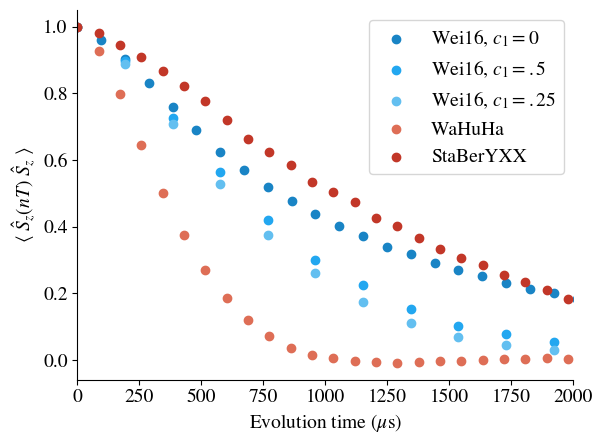

In [6]:
# Test the performance of the disorder generators vai their suspension performance
# e.g. seq_susp = seq + pi + seq + pi, except wei16, which can be tuned to suspension
# with the c1 knob

staber_pi = get_tpc_data("staber_pi.dat", 344)
whh_pi = get_tpc_data("whh_pi.dat", 282)
staberYXX_zz = get_tpc_data("staberYXX_zz.dat", 380)
staberYXX_xx = get_tpc_data("staberYXX_xx.dat", 382)
ken_suspension = get_tpc_data("ken_suspension.dat", 279)
ken_50_pi = get_tpc_data("ken_50_pi.dat", 582)
ken_25_pi = get_tpc_data("ken_25_pi.dat", 583)
t_list = np.arange(0, 25, 1) * 96


plt.scatter(t_list, ken_suspension, label=r"Wei16, $c_1=0$", color=colors[0])
plt.scatter(t_list * 2, ken_50_pi, label=r"Wei16, $c_1=.5$", color=colors[1])
plt.scatter(t_list * 2, ken_25_pi, label=r"Wei16, $c_1=.25$", color=colors[2])
plt.scatter(t_list * (43 * 2 / 96), whh_pi, label="WaHuHa", color=colors[6])
plt.scatter(
    t_list * (43 * 2 / 96), staberYXX_zz[:25], label="StaBerYXX", color=colors[-1]
)

plt.legend()
plt.xlabel(r"Evolution time ($\mu$s)")
plt.xlim([0, 2000])
plt.ylabel(zcorr_str)
# plt.title("Suspension Performance of Disorder Generators")
plt.savefig("supension_performance.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("suspension_performance.png", format="png", dpi=900, bbox_inches="tight")
plt.show()

In [7]:
def find_one_over_e_time(data, times):
    one_over_e_times = {}
    for label, series in data.items():
        initial_value = series[0]
        one_over_e_value = initial_value / np.e
        one_over_e_time = None
        for t, value in zip(times, series):
            if value <= one_over_e_value:
                one_over_e_time = t
                break
        one_over_e_times[label] = one_over_e_time
    return one_over_e_times


# Find 1/e times for the plotted curves
one_over_e_times_ken_suspension = find_one_over_e_time(
    {"ken_suspension": ken_suspension}, t_list
)
one_over_e_times_ken_50_pi = find_one_over_e_time({"ken_50_pi": ken_50_pi}, t_list * 2)
one_over_e_times_whh_pi = find_one_over_e_time(
    {"whh_pi": whh_pi}, t_list * (43 * 2 / 96)
)
one_over_e_times_staberYXX_zz = find_one_over_e_time(
    {"staberYXX_zz": staberYXX_zz[:25]}, t_list * (43 * 2 / 96)
)

# Combine all results
one_over_e_times = {
    **one_over_e_times_ken_suspension,
    **one_over_e_times_ken_50_pi,
    **one_over_e_times_whh_pi,
    **one_over_e_times_staberYXX_zz,
}

print("1/e times for each curve:")
for label, time in one_over_e_times.items():
    print(f"{label}: {time} µs")

1/e times for each curve:
ken_suspension: 1248 µs
ken_50_pi: 960 µs
whh_pi: 516.0 µs
staberYXX_zz: 1376.0 µs


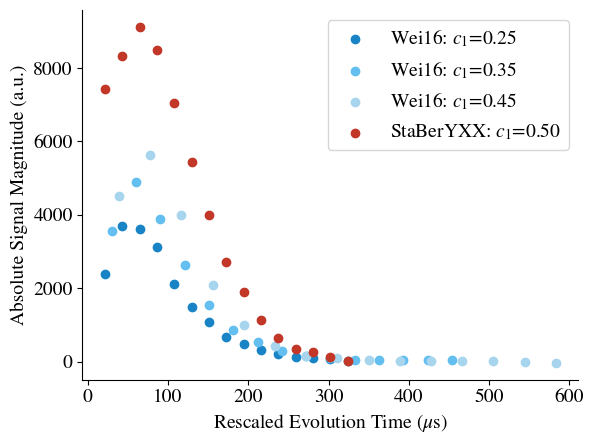

In [8]:
# Test the measurable signal for the disordered state preparation technique
wei16_25 = get_tpc_data("wei16_25.dat", 317, normalize=False)
wei16_35 = get_tpc_data("wei16_35.dat", 318, normalize=False)
wei16_45 = get_tpc_data("wei16_45.dat", 319, normalize=False)
# staber_100 = get_tpc_data("staber_100.dat", 346, normalize=False)
staberYXX_50 = get_tpc_data("staberYXX_50.dat", 353, normalize=False)

tau = 3.6
T = 24 * tau
times = np.arange(1, 16, 1) * T
plt.scatter(0.25 * times, wei16_25, label=r"Wei16: $c_1$=0.25", color=colors[0])
plt.scatter(0.35 * times, wei16_35, label=r"Wei16: $c_1$=0.35", color=colors[2])
plt.scatter(0.45 * times, wei16_45, label=r"Wei16: $c_1$=0.45", color=colors[3])
# plt.scatter(times / 2, staber_100, label=r"Staber: $c_1$=1.00", color=colors[5])
plt.scatter(
    0.5 * times / 2, staberYXX_50, label=r"StaBerYXX: $c_1$=0.50", color=colors[8]
)
plt.legend()
plt.xlabel(r"Rescaled Evolution Time ($\mu$s)")
plt.ylabel("Absolute Signal Magnitude (a.u.)")
plt.savefig("disorder_prep.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("disorder_prep.png", format="png", dpi=900, bbox_inches="tight")
plt.show()

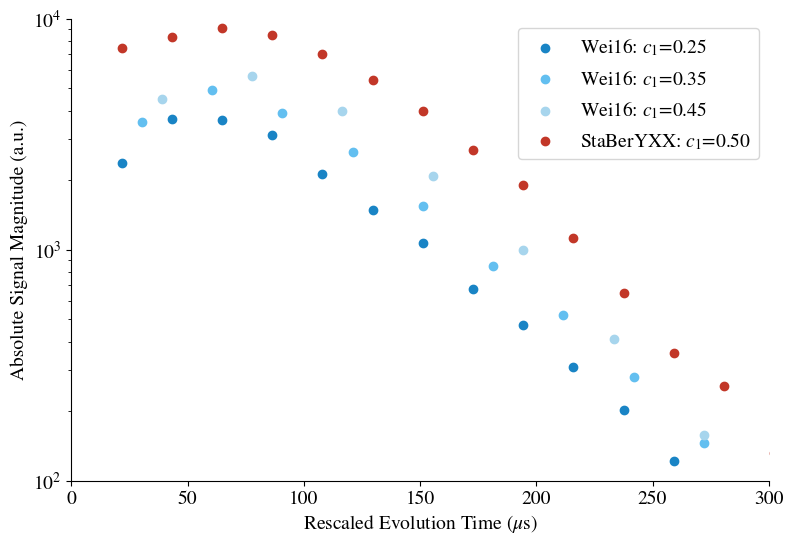

In [9]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_yscale("log")
ax.scatter(0.25 * times, wei16_25, label=r"Wei16: $c_1$=0.25", color=colors[0])
ax.scatter(0.35 * times, wei16_35, label=r"Wei16: $c_1$=0.35", color=colors[2])
ax.scatter(0.45 * times, wei16_45, label=r"Wei16: $c_1$=0.45", color=colors[3])
# ax.scatter(times / 2, staber_100, label=r"Staber: $c_1$=1.00", color=colors[5])
ax.scatter(
    0.5 * times / 2, staberYXX_50, label=r"StaBerYXX: $c_1$=0.50", color=colors[8]
)
ax.legend()
plt.xlim(0, 300)
plt.ylim(1e2, 1e4)
plt.xlabel(r"Rescaled Evolution Time ($\mu$s)")
plt.ylabel("Absolute Signal Magnitude (a.u.)")
plt.savefig("disorder_prep_log.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("disorder_prep_log.png", format="png", dpi=900, bbox_inches="tight")
plt.show()

In [27]:
T = 24*4

def slope_fit(data, start, end, t_list):
    if end > 35:
        return 0
    x = np.log(t_list[start: end])
    X = sm.add_constant(x)
    y = -np.log(data[start:end].flatten())
    ols = sm.OLS(y, X)
    ols_result = ols.fit()
    slopes = ols_result.params[1]
    intercept = ols_result.params[0]
    err = ols_result.conf_int()[1, 1] - ols_result.params[1]
    return slopes,intercept,err

slopes_fit = {}
slopes_err = {}
intercept_fit = {} 

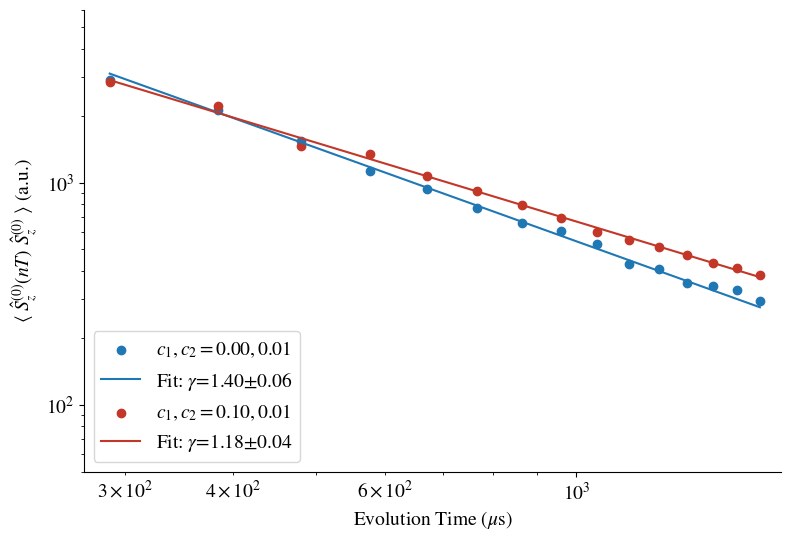

In [42]:
times = np.arange(3*T, 18*T,T)
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_xscale("log")
ax.set_yscale("log")

data = get_tpc_data("c1_0_c2_01.dat", 721, normalize=False,use_real=True)
m,b,err = slope_fit(data,1,12,times)
slopes_fit[(0.0, .01)] = m
slopes_err[(0.0, .01)] = err
intercept_fit[(0.0, .01)] = b
ax.scatter(times,data,label=rf"$c_1,c_2 = 0.00, 0.01$",marker="o")
ax.plot(times, np.exp(-m*np.log(times)-b), label=rf"Fit: $\gamma$={m:.2f}"+ r"$\pm$" + f"{err:.2f}")

data = get_tpc_data("c1_10_c2_01.dat", 730, normalize=False,use_real=True)
m,b,err = slope_fit(data,0,15,times)
slopes_fit[(0.10, .01)] = m
slopes_err[(0.10, .01)] = err
intercept_fit[(0.10, .01)] = b
ax.scatter(times,data,label=rf"$c_1,c_2 = 0.10, 0.01$",marker="o",color=colors[-1])
ax.plot(times, np.exp(-m*np.log(times)-b), label=rf"Fit: $\gamma$={m:.2f}"+ r"$\pm$" + f"{err:.2f}",color=colors[-1])



ax.legend(loc="lower left")
plt.xlim(2.8*T, 18*T)
plt.ylim(5e1,6e3)
plt.xlabel(r"Evolution Time ($\mu$s)")
plt.ylabel(zcorr_loc_str + " (a.u.)")

plt.savefig("diffusion_v_slow.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("diffusion_v_slow.png", format="png", dpi=900, bbox_inches="tight")

plt.show()


In [ ]:
c1, c2 = .05, .01
start, end = 1, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 695, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .01, .01
start, end = 2, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 684, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .06, .01
start, end = 2, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 701, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .07, .01
start, end = 2, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 703, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .08, .01
start, end = 2, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 711, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .00, .01
start, end = 1, 12
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 721, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .09, .01
start, end = 0, 12
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 728, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .11, .01
start, end = 0, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 734, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .12, .01
start, end = 0, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 735, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .15, .01
start, end = 0, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 740, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .2, .01
start, end = 0, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 741, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .02, .01
start, end = 1, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 746, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .03, .01
start, end = 4, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 752, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .04, .01
start, end = 2, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 753, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c:\Users\awsta\Documents\qeg-env\Lib\site-packages\nmrglue\fileio\bruker.py:394: UserWarning: Error reading the pulse program
  warn('Error reading the pulse program')


In [49]:
c1, c2 = .00, .02
start, end = 1, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 762, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .14, .02
start, end = 1, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 769, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .01, .02
start, end = 1, 13
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 806, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .04, .02
start, end = 1, 12
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 811, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .08, .02
start, end = 4, 11
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 816, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .09, .02
start, end = 1, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 822, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .10, .02
start, end = 3, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 823, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .12, .02
start, end = 2, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 831, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

c1, c2 = .15, .02
start, end = 2, 15
c1_str = f"c1_{int(c1 * 100):02d}"
data = get_tpc_data(f"c1_{int(c1 * 100):02d}_c2_{int(c2 * 100):02d}.dat", 837, normalize=False,use_real=True)
m,b,err = slope_fit(data,start,end,times)
slopes_fit[(c1, c2)] = m
slopes_err[(c1, c2)] = err
intercept_fit[(c1, c2)] = b

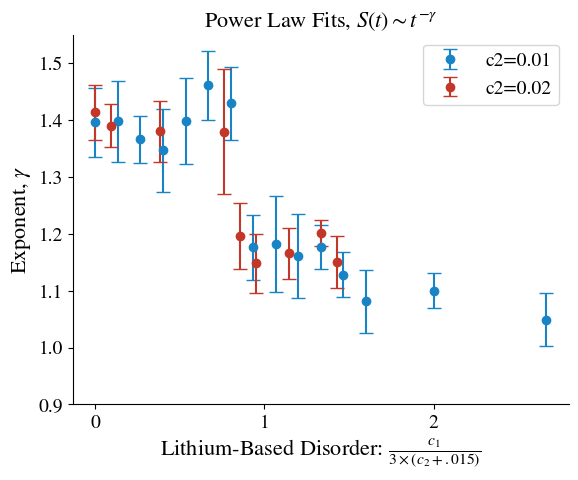

In [89]:
# Organize
unique_c2_values = sorted(set(key[1] for key in slopes_fit.keys()))
slopes_by_c2 = {c2: [] for c2 in unique_c2_values}
errors_by_c2 = {c2: [] for c2 in unique_c2_values}
disorder_by_c2 = {c2: [] for c2 in unique_c2_values}


for key, slope in slopes_fit.items():
    c1, c2 = key
    disorder_strength = (1/3)*c1/(c2+.015)
    slopes_by_c2[c2].append(slope)
    errors_by_c2[c2].append(slopes_err[key])
    disorder_by_c2[c2].append(disorder_strength)
    
#plotting
disorder = np.arange(0, 8, 0.1)

plt.errorbar(disorder_by_c2[0.01], slopes_by_c2[0.01], yerr=errors_by_c2[0.01], fmt='o', capsize=5, label="c2=0.01", color=colors[0])
plt.errorbar(disorder_by_c2[0.02], slopes_by_c2[0.02], yerr=errors_by_c2[0.02], fmt='o', capsize=5, label="c2=0.02", color=colors[-1])
plt.xlabel(r"Lithium-Based Disorder: $\frac{c_1}{3\times(c_2+.015)}$", fontsize=16)
plt.ylabel(r"Exponent, $\gamma$", fontsize=16)
plt.title(r"Power Law Fits, $S(t) \sim t^{-\gamma}$", fontsize=16)
plt.ylim(.9, 1.55)
#plt.plot(disorder, 0.14 * (1 - np.tanh(3.5 * (disorder - 2.6))) + 1.12, label="Tanh Overlay", linestyle='--', color='black')
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))


plt.savefig("power_law_inter_offset.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("power_law_inter_offset.png", format="png", dpi=900, bbox_inches="tight")

plt.show()

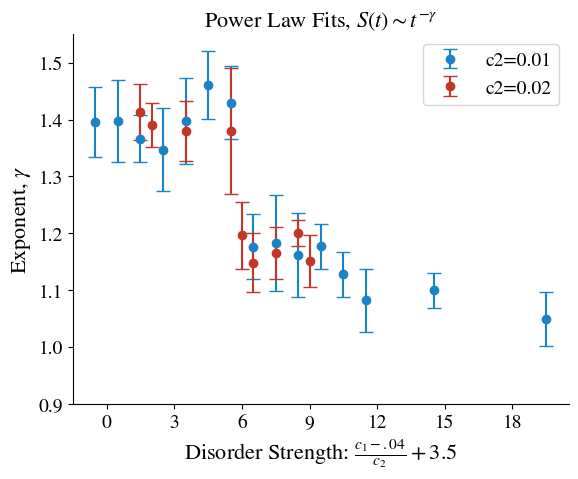

In [88]:
# Organize
unique_c2_values = sorted(set(key[1] for key in slopes_fit.keys()))
slopes_by_c2 = {c2: [] for c2 in unique_c2_values}
errors_by_c2 = {c2: [] for c2 in unique_c2_values}
disorder_by_c2 = {c2: [] for c2 in unique_c2_values}


for key, slope in slopes_fit.items():
    c1, c2 = key
    disorder_strength = (c1 -.04) / (c2) + 3.5
    slopes_by_c2[c2].append(slope)
    errors_by_c2[c2].append(slopes_err[key])
    disorder_by_c2[c2].append(disorder_strength)
    
#plotting
disorder = np.arange(0, 8, 0.1)

plt.errorbar(disorder_by_c2[0.01], slopes_by_c2[0.01], yerr=errors_by_c2[0.01], fmt='o', capsize=5, label="c2=0.01", color=colors[0])
plt.errorbar(disorder_by_c2[0.02], slopes_by_c2[0.02], yerr=errors_by_c2[0.02], fmt='o', capsize=5, label="c2=0.02", color=colors[-1])
plt.xlabel(r"Disorder Strength: $\frac{c_1-.04}{c_2} + 3.5$", fontsize=16)
plt.ylabel(r"Exponent, $\gamma$", fontsize=16)
plt.title(r"Power Law Fits, $S(t) \sim t^{-\gamma}$", fontsize=16)
plt.ylim(.9, 1.55)
#plt.plot(disorder, 0.14 * (1 - np.tanh(3.5 * (disorder - 2.6))) + 1.12, label="Tanh Overlay", linestyle='--', color='black')
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.savefig("power_law_disorder_offset.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("power_law_disorder_offset.png", format="png", dpi=900, bbox_inches="tight")

plt.show()

C:\Users\awsta\AppData\Local\Temp\ipykernel_5448\832759733.py:9: RuntimeWarning: invalid value encountered in sqrt
  D = np.where(disorder_param <= 1, (.5/(disorder_param+.5))*np.sqrt(1-disorder_param**2 ), 0)


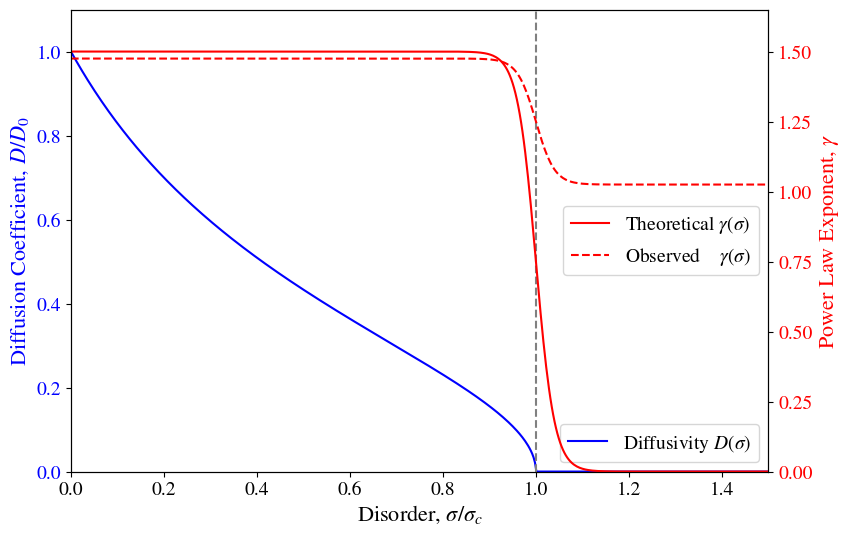

In [93]:
plt.rcParams["axes.spines.right"] = True
plt.rcParams["axes.spines.top"] = True
fig, ax1 = plt.subplots(figsize=(9, 6))

# Define the disorder parameter range
disorder_param = np.linspace(0, 1.5, 500)

# Diffusion coefficient, D
D = np.where(disorder_param <= 1, (.5/(disorder_param+.5))*np.sqrt(1-disorder_param**2 ), 0)

# Power law exponent, γ
gamma = 0.75 * (1 - np.tanh(25 * (disorder_param - 1)))

# Power law exponent, γ
gamma_obs = .75*(1 - .3*np.tanh(25 * (disorder_param - 1))) + .5

# Plot diffusion coefficient
ax1.plot(disorder_param, D, label=r"Diffusivity $D(\sigma)$", color="blue")
ax1.set_xlabel(r"Disorder, $\sigma/\sigma_c$", fontsize=16)
ax1.set_ylabel(r"Diffusion Coefficient, $D/D_0$", color="blue", fontsize=16)
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_ylim(0, 1.1)

# Create a second y-axis for the power law exponent
ax2 = ax1.twinx()
ax2.plot(disorder_param, gamma, color="red", label=r"Theoretical $\gamma(\sigma)$")
ax2.plot(disorder_param, gamma_obs, color="red", linestyle="--", label=r"Observed    $\gamma(\sigma)$")
ax2.set_ylabel(r"Power Law Exponent, $\gamma$", color="red", fontsize=16)
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(0, 1.65)
plt.xlim(0,1.5)

ax2.yaxis.set_major_locator(plt.MultipleLocator(0.25))
ax1.axvline(x=1, color="gray", linestyle="--")


ax2.legend(loc="center right")
ax1.legend(loc="lower right")


plt.savefig("theory_picture.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("theory_picture.png", format="png", dpi=900, bbox_inches="tight")

plt.show()

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False